In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [96]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from keras import layers
import keras
import numpy as np

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from numpy.random import seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

def create_sequences(values, time_steps=128):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

selected = []
data_train = []
losses = []
losses_evaluate = {}
for t in range(1, 20):
    selected = []
    for i in range(1,t+1):
        selected.append((60-1) * (i-1) + 1 )

    data_train = []
    test = {}
    for cid in range(34):
        test[str(cid)] = []
        data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/data/SKAB/federated_data/{cid}.csv', sep = ';')
        scaler = StandardScaler()
        data = data.head(t * 60)

        data.index = pd.to_datetime(data['datetime'])
        data.drop('datetime', axis = 1, inplace=True)
        train = data.copy()
        train.drop(['anomaly', 'changepoint'], axis = 1, inplace = True)
        train = train.values
        scaler.fit(train)
        train = scaler.transform(train)

        #pca = PCA(n_components=2)
        #train = pca.fit_transform(train)

        X = create_sequences(train, time_steps=59)
        for s in selected:
            try:
                x = X[s]
                data_train.append(x)
            except IndexError:
                continue

        test[str(cid)] = data_train[-1]
    #data_train = np.stack(data_train, axis = 1)#.squeeze(axis = 0)
    data_train = np.array(data_train)
    print(data_train.shape)
    X = data_train.copy()

    if t == 1:
        model = keras.Sequential(
                    [
                        layers.Input(shape=(X.shape[1], X.shape[2])),#, X.shape[3])),

                        #layers.Dropout(rate=0.2),
                        layers.Conv1D(
                            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
                        ),

                        # layers.Dropout(rate=0.2),
                        layers.Conv1D(
                            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
                        ),

                        layers.Conv1DTranspose(
                            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
                        ),

                        layers.Conv1DTranspose(
                            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
                        ),
                        layers.Conv1DTranspose(
                            filters=1, kernel_size=7, padding="same"),

                        #layers.Dense(X.shape[2])
                    ]
                    )
    model.compile(optimizer='adam', loss='mse')

    n_epochs = 100
    hist =  model.fit(X, X,
                epochs = n_epochs, batch_size = 32, verbose=0)
        
    losses.append(hist.history['loss'][-1])

    for idx_cid in test:
        if t == 1:
            losses_evaluate[idx_cid] = []
            losses_evaluate[idx_cid].append(pd.Series(np.sum(np.mean(np.abs(test[idx_cid] - model.predict(test[idx_cid][np.newaxis,:,:], verbose = 0)), axis=1), axis=1)).values[0])
        else:
            losses_evaluate[idx_cid].append(pd.Series(np.sum(np.mean(np.abs(test[idx_cid] - model.predict(test[idx_cid][np.newaxis,:,:], verbose = 0)), axis=1), axis=1)).values[0])
        

#model.save_weights('./checkpoints/my_checkpoint_PCA')


(34, 59, 8)
(68, 59, 8)
(102, 59, 8)
(136, 59, 8)
(170, 59, 8)
(204, 59, 8)
(238, 59, 8)
(272, 59, 8)
(306, 59, 8)
(340, 59, 8)
(374, 59, 8)
(408, 59, 8)
(441, 59, 8)
(473, 59, 8)
(505, 59, 8)
(535, 59, 8)
(564, 59, 8)
(592, 59, 8)
(615, 59, 8)


In [107]:
#model.save_weights('./checkpoints/my_checkpoint_certo')

<AxesSubplot:>

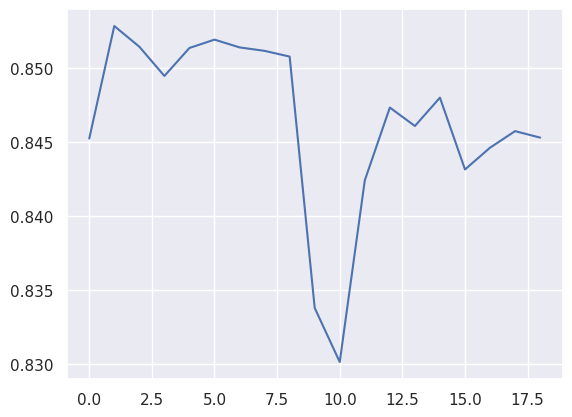

In [97]:
sns.lineplot(losses)

<AxesSubplot:>

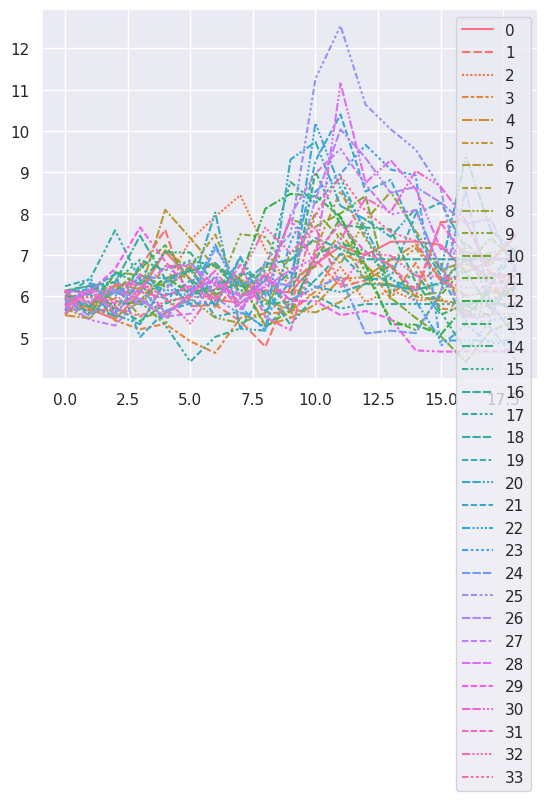

In [98]:
sns.lineplot(losses_evaluate)

In [99]:
pd.Series(losses_evaluate['0']).diff()[:10]

0         NaN
1   -0.430425
2   -0.243897
3    0.640497
4    0.999136
5   -0.666864
6   -0.500017
7   -0.073146
8    0.302057
9   -0.052934
dtype: float64

In [100]:
pd.Series(losses_evaluate[str(cid)]).diff()[:1]#.tail(1).values[0]

0   NaN
dtype: float64

In [101]:

for t in range(3,19):
    if t == 3:
        anomalies = {}
        anomalies2 = {}
        for cid in range(34):
            anomalies[str(cid)] = [0,0,0]
            anomalies2[str(cid)] = [0,0,0]
    for cid in range(34):

        #log_data = log_data[log_data['cid'] == cid]
        #last_loss = log_data['loss'].tail(1).values[0]
        #print(t)
        last_loss = losses_evaluate[str(cid)][t-1]
        loss = losses_evaluate[str(cid)][t]

        if t>=3:

            diff = loss - last_loss #o quanto a loss cresce no inicio de um round
            #print(diff, pd.Series(losses_evaluate[str(cid)]).diff()[:t+1].tail(1).values[0])
        else: 
            
            diff = 0

        #mean_diff = log_data['diff'].tail(3).mean() #media do crescimento nos ultimos 3 rounds
        mean_diff = pd.Series(losses_evaluate[str(cid)]).diff()[:t].mean()


        anomaly = 0
        if diff >= 1.5*mean_diff: #se cresceu mais que o esperado, é a nomalia
            anomaly = 1

        anomalies[str(cid)].append(anomaly)

        anomaly2 = 0
        #last_losses = log_data['loss'].tail(3).values
        last_losses = pd.Series(losses_evaluate[str(cid)])[:t].tail(3).values
        if (loss - last_losses[-1]) > 0:
            if (last_losses[-1] - last_losses[-2]) > 0:
                #if (last_losses[-2] - last_losses[-3]) > 0:
                anomaly2 = 1 #se a loss tem subido nos ultimos 3 rounds

        anomalies2[str(cid)].append(anomaly2)


In [102]:
anom = []
for i in anomalies:
    anom.extend(anomalies[i])

anom2 = []
for i in anomalies2:
    anom2.extend(anomalies2[i])

In [103]:
l = []
for i in range(1,20):
    l.extend(list(np.ones(34)*i))

In [104]:
data_eval = pd.DataFrame()
data_eval['round'] = l
data_eval['anomaly'] = anom
data_eval['anomaly2'] = anom2

In [105]:
data_eval.head()
data_eval['true_anomaly'] = data_eval['round'].apply(lambda x: 1 if x>=9 else 0)

data_eval['anomaly12'] = data_eval['anomaly'] + data_eval['anomaly2'] 
data_eval['anomaly12'] = data_eval['anomaly12'].apply(lambda x: 1 if x==2 else x)

print('Anomaly1 ',f1_score(data_eval['anomaly'], data_eval['true_anomaly']),
    precision_score(data_eval['anomaly'], data_eval['true_anomaly']),
    recall_score(data_eval['anomaly'], data_eval['true_anomaly']),
    accuracy_score(data_eval['anomaly'], data_eval['true_anomaly']))

print('Anomaly2 ',f1_score(data_eval['anomaly2'], data_eval['true_anomaly']),
        precision_score(   data_eval['anomaly2'], data_eval['true_anomaly']),
        recall_score(      data_eval['anomaly2'], data_eval['true_anomaly']),
        accuracy_score(    data_eval['anomaly2'], data_eval['true_anomaly']))
    
print('Anomaly12 ',f1_score(data_eval['anomaly12'], data_eval['true_anomaly']),
        precision_score(    data_eval['anomaly12'], data_eval['true_anomaly']),
        recall_score(       data_eval['anomaly12'], data_eval['true_anomaly']),
        accuracy_score(     data_eval['anomaly12'], data_eval['true_anomaly']))

Anomaly1  0.4644549763033175 0.393048128342246 0.5675675675675675 0.47523219814241485
Anomaly2  0.25203252032520324 0.1657754010695187 0.5254237288135594 0.43034055727554177
Anomaly12  0.47604327666151464 0.4117647058823529 0.5641025641025641 0.47523219814241485


<AxesSubplot:xlabel='round', ylabel='anomaly'>

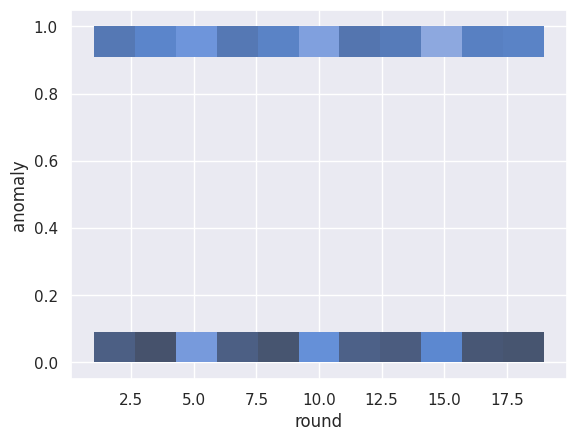

In [110]:
sns.histplot(x = data_eval['round'], y = data_eval['anomaly'])#, hue = data['anom_true'], bins = 20)

In [106]:
#first try
#Anomaly1  0.46518987341772156 0.393048128342246 0.5697674418604651 0.47678018575851394
#Anomaly2  0.2336065573770492 0.15240641711229946 0.5 0.42105263157894735
#Anomaly12  0.47131782945736433 0.40641711229946526 0.5608856088560885 0.47213622291021673

#Anomaly1  0.4644549763033175 0.393048128342246 0.5675675675675675 0.47523219814241485
#Anomaly2  0.25203252032520324 0.1657754010695187 0.5254237288135594 0.43034055727554177
#Anomaly12  0.47604327666151464 0.4117647058823529 0.5641025641025641 0.47523219814241485